In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

Reading Animelist.csv

In [4]:
import os

In [5]:
INPUT_DIR = os.path.join("..", "artifacts","raw")

In [6]:
rating_df = pd.read_csv(INPUT_DIR + "/animelist.csv",usecols=["user_id","anime_id","rating"])

In [7]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [8]:
len(rating_df)

25081517

Data Processing

In [9]:
n_rating = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_rating[n_rating >= 400].index)].copy()

In [10]:
rating_df

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0
...,...,...,...
25081263,81390,6213,0
25081264,81390,113,0
25081265,81390,2608,0
25081266,81390,6425,0


In [11]:
n_rating

user_id
20807    17546
63900    16774
50485    16639
68042    14638
11100    14429
         ...  
26139        1
26136        1
26           1
5007         1
33733        1
Name: count, Length: 75004, dtype: int64

In [12]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
avg_rating = rating_df["rating"].mean()

In [13]:
print(min_rating)
print(max_rating)
print(avg_rating)

0
10
4.061312518892976


In [14]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [15]:
rating_df.duplicated().sum()

np.int64(1)

In [16]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [17]:
rating_df = rating_df.drop_duplicates()

In [18]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user2user_decoded = {i: x for i, x in enumerate(user_ids)}

In [19]:
user2user_encoded

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [20]:
user2user_decoded

{0: 2,
 1: 6,
 2: 12,
 3: 16,
 4: 17,
 5: 19,
 6: 21,
 7: 41,
 8: 42,
 9: 44,
 10: 47,
 11: 53,
 12: 55,
 13: 60,
 14: 66,
 15: 73,
 16: 74,
 17: 85,
 18: 89,
 19: 90,
 20: 94,
 21: 98,
 22: 102,
 23: 108,
 24: 111,
 25: 112,
 26: 120,
 27: 121,
 28: 122,
 29: 135,
 30: 145,
 31: 146,
 32: 147,
 33: 153,
 34: 155,
 35: 156,
 36: 172,
 37: 174,
 38: 184,
 39: 190,
 40: 193,
 41: 194,
 42: 198,
 43: 204,
 44: 205,
 45: 209,
 46: 214,
 47: 219,
 48: 222,
 49: 227,
 50: 228,
 51: 235,
 52: 238,
 53: 240,
 54: 243,
 55: 248,
 56: 251,
 57: 252,
 58: 257,
 59: 264,
 60: 267,
 61: 272,
 62: 274,
 63: 275,
 64: 284,
 65: 285,
 66: 286,
 67: 290,
 68: 291,
 69: 293,
 70: 300,
 71: 301,
 72: 306,
 73: 308,
 74: 310,
 75: 313,
 76: 314,
 77: 316,
 78: 320,
 79: 321,
 80: 324,
 81: 325,
 82: 326,
 83: 327,
 84: 330,
 85: 336,
 86: 340,
 87: 345,
 88: 346,
 89: 349,
 90: 350,
 91: 366,
 92: 367,
 93: 371,
 94: 372,
 95: 375,
 96: 381,
 97: 382,
 98: 386,
 99: 389,
 100: 398,
 101: 405,
 102: 406,
 

Reading Animelist.csv

In [21]:
import os

In [22]:
INPUT_DIR = os.path.join("..", "artifacts","raw")

In [23]:
rating_df = pd.read_csv(INPUT_DIR + "/animelist.csv",usecols=["user_id","anime_id","rating"])

In [24]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [25]:
len(rating_df)

25081517

Data Processing

In [26]:
n_rating = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_rating[n_rating >= 400].index)].copy()

In [27]:
rating_df

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0
...,...,...,...
25081263,81390,6213,0
25081264,81390,113,0
25081265,81390,2608,0
25081266,81390,6425,0


In [28]:
n_rating

user_id
20807    17546
63900    16774
50485    16639
68042    14638
11100    14429
         ...  
26139        1
26136        1
26           1
5007         1
33733        1
Name: count, Length: 75004, dtype: int64

In [29]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
avg_rating = rating_df["rating"].mean()

In [30]:
print(min_rating)
print(max_rating)
print(avg_rating)

0
10
4.061312518892976


In [31]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [32]:
rating_df.duplicated().sum()

np.int64(1)

In [33]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [34]:
rating_df = rating_df.drop_duplicates()

In [35]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user2user_decoded = {i: x for i, x in enumerate(user_ids)}
rating_df['user'] = rating_df['user_id'].map(user2user_encoded)
n_users = len(user2user_encoded)

C:\Users\Aditya_Bansal\AppData\Local\Temp\ipykernel_19784\2924641195.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['user'] = rating_df['user_id'].map(user2user_encoded)


In [36]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

C:\Users\Aditya_Bansal\AppData\Local\Temp\ipykernel_19784\3348708604.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)


In [37]:
n_anime = len(anime2anime_encoded)

In [38]:
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)

In [39]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [40]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [41]:
X_train , X_test , y_train , y_test = (
    X[:train_indices],
    X[train_indices :],
    y[:train_indices],
    y[train_indices:],
)

In [42]:
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

In [43]:
X_train_array

[array([ 7021, 18906,  4508, ...,  9007,  1463, 16356], shape=(16387365,)),
 array([2695, 2901, 1444, ...,  821,  561, 1203], shape=(16387365,))]

MODEL ARCHITECTURE

In [44]:
def RecommenderNet():
    embedding_size =128

    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name="dot_product" , normalize=True , axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam')
    return model

In [45]:
model = RecommenderNet()

In [46]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │  2,693,120 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,247,040 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,940,166 (18.85 MB)

 Trainable params: 4,940,164 (18.85 MB)

 Non-trainable params: 2 (8.00 B)

In [47]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [48]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)

In [49]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [50]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - loss: 0.7262 - mae: 0.3700 - mse: 0.1720 - val_loss: 0.7334 - val_mae: 0.3704 - val_mse: 0.1729 - learning_rate: 1.0000e-05
Epoch 2/20
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - loss: 0.7165 - mae: 0.3677 - mse: 0.1677 - val_loss: 0.7226 - val_mae: 0.3683 - val_mse: 0.1682 - learning_rate: 1.8000e-05
Epoch 3/20
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - loss: 0.7027 - mae: 0.3642 - mse: 0.1614 - val_loss: 0.7071 - val_mae: 0.3647 - val_mse: 0.1610 - learning_rate: 2.6000e-05
Epoch 4/20
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 44s 26ms/step - loss: 0.6853 - mae: 0.3588 - mse: 0.1530 - val_loss: 0.6866 - val_mae: 0.3573 - val_mse: 0.1511 - learning_rate: 3.4000e-05
Epoch 5/20
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 44s 26ms/step - loss: 0.6463 - mae: 0.3338 - mse: 0.1343 - val_loss: 0.6275 - val_mae: 0.3082 - val_mse: 0.1231 - learning_rate: 4.2000e-05
Epoch 6/20
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - loss: 0.5823 - mae: 0.2808 - mse

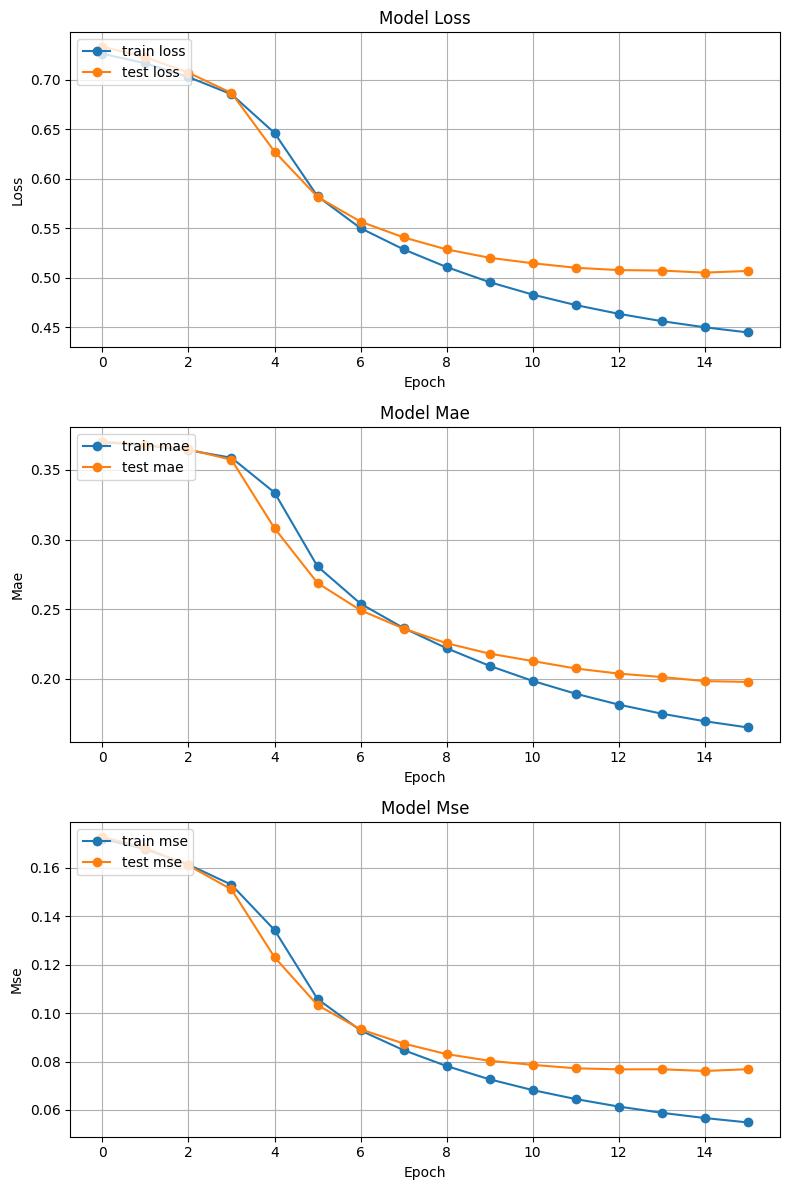

In [51]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [52]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [53]:
anime_weights = extract_weights("anime_embedding",model)

In [54]:
user_weights = extract_weights("user_embedding",model)

Reading Anime.csv

In [55]:
df = pd.read_csv(INPUT_DIR + "/anime.csv",low_memory=True)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [56]:
df = df.replace('Unknown',np.nan)

In [57]:
def getAnimeName(anime_id):
    try:
        name = df[df['anime_id'] == anime_id]['eng_version'].values[0]
        if name is np.nan:
            name = df[df['anime_id'] == anime_id]['name'].values[0]
        return name
    except:
        print("Unknown")

In [58]:
df['anime_id'] = df['MAL_ID']
df['eng_version'] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x:getAnimeName(x))

Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown


In [59]:
df.sort_values(by=['Score'],inplace=True,ascending=False,kind='quicksort',na_position='last')

In [60]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [61]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [62]:
df = df[['anime_id','eng_version',"Score",'Genres',"Episodes","Type","Premiered",'Members']]

In [63]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [64]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df['anime_id']==anime]
    if isinstance(anime,str):
        return df[df['eng_version']==anime]

In [65]:
getAnimeFrame('Steins;Gate',df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


AnimeWithSynopsis.csv

In [66]:
cols = ['MAL_ID','Name','Genres','sypnopsis'] 

In [67]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [68]:
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [69]:
def getSynopsis(anime,df):
    if isinstance(anime,int):
        return df[df['MAL_ID']==anime]['sypnopsis'].values[0]
    if isinstance(anime,str):
        return df[df['Name']==anime]['sypnopsis'].values[0]

CONTENT/ITEM BASED RECOMMENDOR SYSTEM

In [70]:
pd.set_option("max_colwidth", None)

In [71]:
def find_similar_animes(name,anime_weights,anime2anime_encoded,anime2anime_decoded,df,synopsis_df,n=10,return_dist=False,neg=False):
        index = getAnimeFrame(name,df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)
        weights = anime_weights
        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        
        if return_dist:
            return dists, closest

        SimilarityArr = []
        for close in closest:
            decoded_id = anime2anime_decoded.get(close)
            synopsis = getSynopsis(decoded_id,synopsis_df)

            anime_frame = getAnimeFrame(decoded_id,df)

            name = anime_frame.eng_version.values[0]
            genres = anime_frame.Genres.values[0]

            SimilarityArr.append({
                "anime_id":decoded_id,
                'name':name,
                'genres':genres,
                'similarity':dists[close],
                'synopsis':synopsis
            })
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [72]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
)

,name,genres,similarity,synopsis
9,Code Geass:Lelouch of the Rebellion R2,"Action, Military, Sci-Fi, Super Power, Drama, Mecha",0.726051,"One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."
8,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",0.724965,"Otonashi awakens only to learn he is dead. A rifle-toting girl named Yuri explains that they are in the afterlife, and Otonashi realizes the only thing he can remember about himself is his name. Yuri tells him that she leads the Shinda Sekai Sensen (Afterlife Battlefront) and wages war against a girl named Tenshi. Unable to believe Yuri's claims that Tenshi is evil, Otonashi attempts to speak with her, but the encounter doesn't go as he intended. Otonashi decides to join the SSS and battle Tenshi, but he finds himself oddly drawn to her. While trying to regain his memories and understand Tenshi, he gradually unravels the mysteries of the afterlife."
7,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",0.723797,"""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosopher's Stone, but their country's murky history as well. In between finding a serial killer and racing against time, Edward and Alphonse must ask themselves if what they are doing will make them human again... or take away their humanity."
6,Code Geass:Lelouch of the Rebellion,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School",0.723709,"In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the ma

USER BASED RECOMMENDER SYSTEM

In [ ]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

In [74]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,42920,0.523601
8,37393,0.470339
7,26237,0.467013
6,11011,0.466299
5,20956,0.456446
4,55704,0.445829
3,70505,0.445576
2,12783,0.445018
1,23503,0.444655
0,66245,0.444368


In [75]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [76]:
from collections import defaultdict

In [77]:
def getFavGenres(frame,plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)
    genres_list = []
    for genres in frame['Genres']:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()]+=1
    if plot:
        showWordCloud(all_genres)
    return genres_list

In [78]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenres(anime_df_rows,plot)

    return anime_df_rows

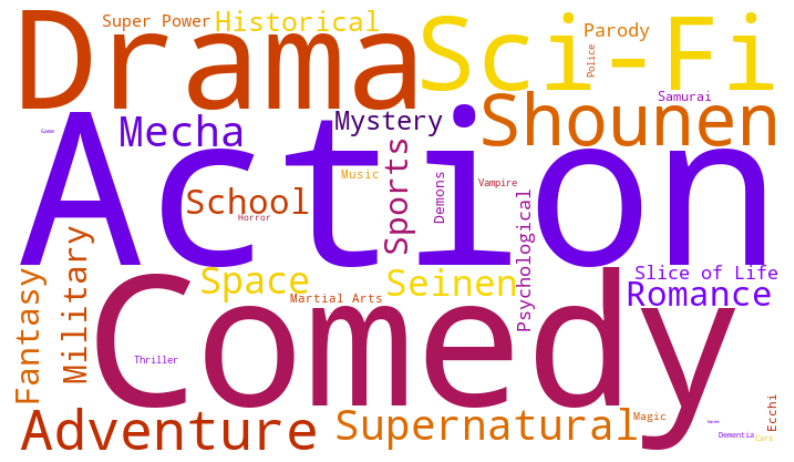

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,None,"Action, Adventure, Fantasy, Shounen"


In [79]:
get_user_preferences(11880 , rating_df, df , plot=True)

In [80]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)

In [81]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

In [82]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

In [83]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=1)

,n,anime_name,Genres,Synopsis
0,10,Steins;Gate,"Thriller, Sci-Fi","The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed ""Daru."" The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the ""Phone Microwave,"" which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn't provide anything concrete in Okabe's search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory and practicality. Forced across the diverging threads of past and present, Okabe must shoulder the burdens that come with holding the key to the realm of time."


In [84]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 


In [85]:
hybrid_recommendation(11880)

['Steins;Gate', 'Fate/Zero Season 2', 'Nisekoi:False Love', 'Soul Eater', 'Code Geass:Lelouch of the Rebellion', 'Attack on Titan', 'Dusk Maiden of Amnesia', 'Bunny Drop', 'Code Geass:Lelouch of the Rebellion R2', 'Re:ZERO -Starting Life in Another World-']


['Fullmetal Alchemist:Brotherhood',
 'Death Note',
 'Steins;Gate',
 'Fate/Zero Season 2',
 'Code Geass:Lelouch of the Rebellion',
 'Attack on Titan',
 'Code Geass:Lelouch of the Rebellion R2',
 'Angel Beats!',
 'Fate/Zero',
 'No Game, No Life']